# Instructions for accessing the shared folder with images
# 1. Open the Google Drive link: https://drive.google.com/drive/folders/1VJXE4h-gDLc1NTxj_Cwq8zB6RjcsekN_?usp=sharing
# 2. Click "Add to Drive" to add the folder to your Google Drive.
# 3. Mount Google Drive in this Colab notebook.

In [6]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.4 MB/s eta 0:00:00


In [ ]:
# import import_ipynb
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import glob
import cv2 as cv2
import os
import numpy as np
import pandas as pd
import shap
import json
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# img = image.load_img("/Users/rodrigorenteria/Desktop/Computer_vision/base_data/training/gun/2.jpeg")

In [ ]:
# plt.imshow(img)

In [9]:
cv2.imread("/content/drive/MyDrive/base_data/training/gun/2.jpeg").shape

(191, 264, 3)

In [10]:
train = ImageDataGenerator(rescale = 1/255)
validation = ImageDataGenerator(rescale = 1/255)

In [11]:
train_dataset = train.flow_from_directory("/content/drive/MyDrive/base_data/training/",
                                          target_size = (200,200),
                                          batch_size = 3,
                                          classes=['gun', 'nogun'],
                                          class_mode = 'binary')
validation_dataset = train.flow_from_directory("/content/drive/MyDrive/base_data/validation/",
                                          target_size = (200,200),
                                          batch_size = 3,
                                            classes=['gun', 'nogun'],
                                          class_mode = 'binary')

Found 198 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [12]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),activation = 'relu', input_shape = (200,200,3)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                    tf.keras.layers.RandomFlip("horizontal",input_shape=(200,200,3)),
                                    tf.keras.layers.RandomRotation(0.1),
                                    tf.keras.layers.RandomZoom(0.1),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0,2),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dense(1,activation='sigmoid')
                                    ])

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 random_flip (RandomFlip)    (None, 46, 46, 64)        0

In [ ]:
history = model.fit(train_dataset, batch_size = 32,
                      epochs = 40,
                      validation_data = validation_dataset)

Epoch 1/40
66/66 [==============================] - 42s 596ms/step - loss: 0.8060 - accuracy: 0.5303 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/40
66/66 [==============================] - 18s 276ms/step - loss: 0.7449 - accuracy: 0.6010 - val_loss: 0.6752 - val_accuracy: 0.6053
Epoch 3/40
66/66 [==============================] - 18s 277ms/step - loss: 0.6859 - accuracy: 0.6162 - val_loss: 0.5941 - val_accuracy: 0.7368
Epoch 4/40
66/66 [==============================] - 19s 284ms/step - loss: 0.6497 - accuracy: 0.6768 - val_loss: 0.5316 - val_accuracy: 0.7895
Epoch 5/40
66/66 [==============================] - 18s 270ms/step - loss: 0.5899 - accuracy: 0.7172 - val_loss: 0.4903 - val_accuracy: 0.7632
Epoch 6/40
66/66 [==============================] - 19s 282ms/step - loss: 0.5173 - accuracy: 0.7626 - val_loss: 0.9150 - val_accuracy: 0.6579
Epoch 7/40
66/66 [==============================] - 19s 293ms/step - loss: 0.4894 - accuracy: 0.7929 - val_loss: 0.5521 - val_accuracy: 0.7105

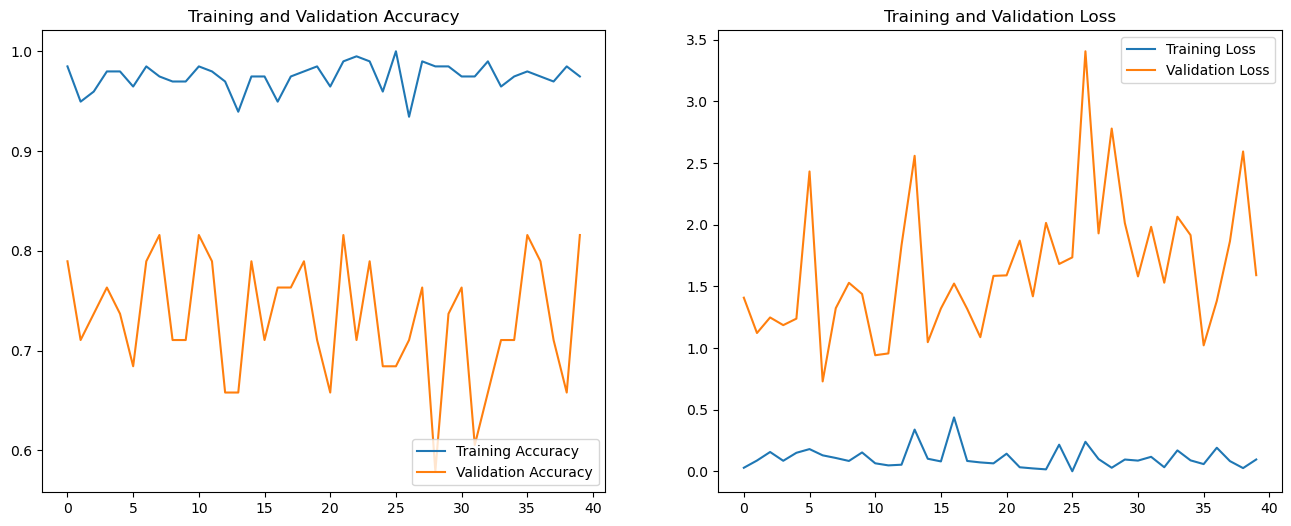

13/13 [==============================] - 0s 20ms/step


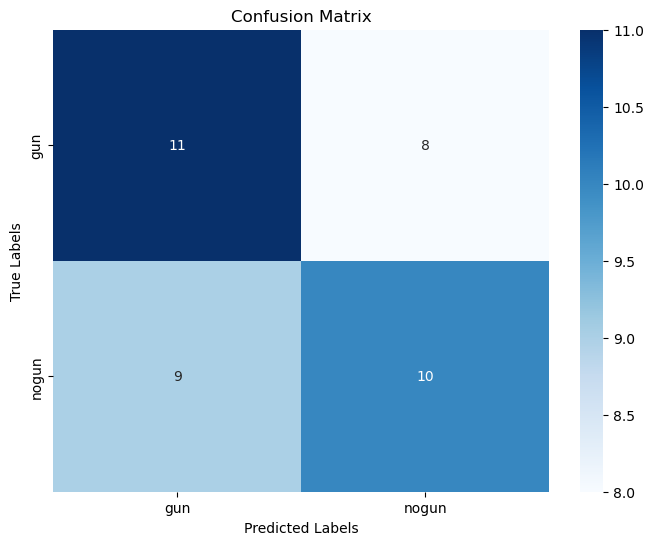

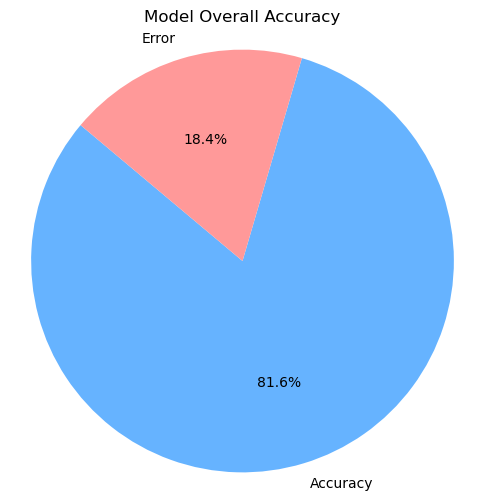

13/13 [==============================] - 0s 15ms/step - loss: 1.5913 - accuracy: 0.8158
Overall Accuracy: 81.58%


In [ ]:
model.save_weights('model_weights_after_40_epochs.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(40)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Generate predictions for the validation dataset
validation_predictions = model.predict(validation_dataset)

# Get the true labels for the validation dataset
true_labels = validation_dataset.classes

# Generate a confusion matrix
cm = confusion_matrix(true_labels, validation_predictions > 0.5)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['gun', 'nogun'], yticklabels=['gun', 'nogun'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

accuracy_percentage = overall_accuracy * 100
error_percentage = 100 - accuracy_percentage

# Create a pie chart
labels = ['Accuracy', 'Error']
sizes = [accuracy_percentage, error_percentage]
colors = ['#66b3ff', '#ff9999']  # Blue for accuracy, Red for error

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Model Overall Accuracy')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

overall_accuracy = model.evaluate(validation_dataset)[1]
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')


RUN THE FOLLOWING CODE, HERE YOU CAN UPLOAD AN IMAGE TO THE FOLLOWING FOLDER THAT WAS PREVIOUSLY 

Hello! Please upload a JPEG image to the 'CapstoneFolder/Computer_vision/base_data/testing' folder.
Once uploaded, please enter the filename,ex : ('image1.jpg') program will access the image and predict whether it contains a gun or not.
Enter here: image179.jpg


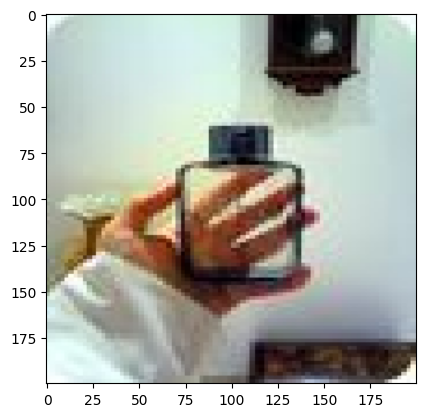

1/1 [==============================] - 0s 283ms/step
There is no gun


In [16]:

print("Hello! Please upload a JPEG image to the 'CapstoneFolder/Computer_vision/base_data/testing' folder.")
print("Once uploaded, please enter the filename,ex : ('image1.jpg') program will access the image and predict whether it contains a gun or not.")

dir_path = '/content/drive/MyDrive/base_data/testing'
# model.evaluate(validation_dataset)
yes = True
while(yes):
    file = input("Enter here: ")
    for i in os.listdir(dir_path):
        if not i.startswith('.') and i == file :
            img = image.load_img(dir_path+'/'+i, target_size=(200,200,3))
            plt.imshow(img)
            plt.show()

            X = image.img_to_array(img)
            X = np.expand_dims(X,axis = 0)
            images = np.vstack([X])
            val = model.predict(images)
            if val == 0:
                print("There is a gun(s)")
                yes = False
                break
            else:
                print("There is no gun")
                yes = False
                break